### Importing Libraries
Import the required libraries for data analysis.

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader

import snntorch as snn
from snntorch import utils

#### Dataset

In [2]:
class GraphDataset(Dataset):
    FILE_PATH = ''
    
    def __init__(self, user_id=None, label_list=None, num_samples=None, secs=None):
        self.user_id = user_id
        self.label_list = label_list
        self.num_samples = num_samples
        self.secs = secs
        
        self.data, self.labels = self.load_data(user_id, label_list, secs)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.Tensor(self.data[idx]), self.labels[idx]
    
    def load_data(self, user_id, label_list, secs):
        data = list()
        labels = list()
        
        for i in range(len(label_list)):
            for j in range(1, self.num_samples + 1):
                try:
                    adjMatrix = scipy.io.loadmat(
                        self.FILE_PATH + str(user_id) +
                        '_label' + str(label_list[i]) +
                        '_item' + str(j) + '.mat')
                    
                except Exception as e:
                    print(f"Load fail: {e}")
                    continue
                    
                if secs == 1:
                    tmpAdjMatrix = adjMatrix['fullMatrix'][np.newaxis, :, :]
                else:
                    tmpAdjMatrix = list()
                    for k in range(self.secs):
                        tmpAdjMatrix.append(adjMatrix['fullMatrix'][:, :, k])
                                        
                data.append(np.array(tmpAdjMatrix))
                labels.append(label_list[i])
                                
        if not data or not labels:
            raise RuntimeError("No data or labels loaded.")
                    
        data = torch.tensor(np.stack(data), dtype=torch.float32)
                
        label_dict = {label: index for index, label in enumerate(self.label_list)}
        new_label_list = [label_dict[label] for label in labels]
        labels = torch.tensor(new_label_list, dtype=torch.long)
        
        return data, labels

In [3]:
def create_dataset(user_id, secs, num_samples, label_list, batch_size):
    full_dataset = GraphDataset(user_id=user_id, label_list=label_list,
                                num_samples=num_samples, secs=secs)
    
    train_size = int(0.75 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

#### Neural Network

In [4]:
class SNN(nn.Module):
    NUM_HIDDEN = 10
    BETA = 0.95
    
    def __init__(self, num_steps, num_inputs, label_list):
        super().__init__()
        
        self.num_steps = num_steps
        self.num_inputs = num_inputs
        self.num_outputs = len(label_list)

        # Initialize layers
        self.fc1 = nn.Linear(self.num_inputs, self.NUM_HIDDEN)
        self.lif1 = snn.Leaky(beta = self.BETA)
        self.fc2 = nn.Linear(self.NUM_HIDDEN, self.num_outputs)
        self.lif2 = snn.Leaky(beta = self.BETA)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(self.num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [5]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc * 100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc * 100:.2f}%")

def train_printer(data, targets, epoch, counter, iter_counter, loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [6]:
def training_network(net, train_loader, test_loader, batch_size):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
    
    num_epochs = 10
    loss_hist = []
    test_loss_hist = []
    counter = 0

    # Outer training loop
    for epoch in range(num_epochs):
        iter_counter = 0
        train_batch = iter(train_loader)

        # Minibatch training loop
        for data, targets in train_batch:
            
            data = data.to(device)
            targets = targets.to(device)

            # forward pass
            net.train()
            spk_rec, mem_rec = net(data.view(batch_size, -1))

            # initialize the loss & sum over time
            loss_val = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                loss_val += loss(mem_rec[step], targets)

            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())

            # Test set
            with torch.no_grad():
                net.eval()
                test_data, test_targets = next(iter(test_loader))
                test_data = test_data.to(device)
                test_targets = test_targets.to(device)

                # Test set forward pass
                test_spk, test_mem = net(test_data.view(batch_size, -1))

                # Test set loss
                test_loss = torch.zeros((1), dtype=dtype, device=device)
                for step in range(num_steps):
                    test_loss += loss(test_mem[step], test_targets)
                test_loss_hist.append(test_loss.item())

                # Print train/test loss/accuracy
                if counter % 50 == 0:
                    train_printer(
                        data, targets, epoch,
                        counter, iter_counter,
                        loss_hist, test_loss_hist,
                        test_data, test_targets)
                counter += 1
                iter_counter +=1
    return loss_hist, test_loss_hist

In [7]:
def loss_printer(loss_hist, test_loss_hist):
    fig = plt.figure(facecolor="w", figsize=(10, 5))
    plt.plot(loss_hist)
    plt.plot(test_loss_hist)
    plt.title("Loss Curves")
    plt.legend(["Train Loss", "Test Loss"])
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

In [8]:
def test_network(net, test_loader):
    total = 0
    correct = 0

    with torch.no_grad():
        net.eval()
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)

            # forward pass
            test_spk, _ = net(data.view(data.size(0), -1))

            # calculate total accuracy
            _, predicted = test_spk.sum(dim=0).max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
    return correct, total

In [9]:
def test_printer(correct, total):
    print(f"Total correctly classified test set images: {correct}/{total}")
    print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

### Calculation of the accuracies





##################################################
#                     User 1                     #
##################################################


Epoch 0, Iteration 0
Train Set Loss: 46.18
Test Set Loss: 37.56
Train set accuracy for a single minibatch: 24.44%
Test set accuracy for a single minibatch: 28.89%


Epoch 1, Iteration 14
Train Set Loss: 35.34
Test Set Loss: 35.66
Train set accuracy for a single minibatch: 30.00%
Test set accuracy for a single minibatch: 17.78%


Epoch 2, Iteration 28
Train Set Loss: 35.32
Test Set Loss: 35.07
Train set accuracy for a single minibatch: 22.22%
Test set accuracy for a single minibatch: 35.56%


Epoch 4, Iteration 6
Train Set Loss: 34.94
Test Set Loss: 35.66
Train set accuracy for a single minibatch: 30.00%
Test set accuracy for a single minibatch: 21.11%


Epoch 5, Iteration 20
Train Set Loss: 34.78
Test Set Loss: 35.28
Train set accuracy for a single minibatch: 34.44%
Test set accuracy for a single minibatch: 25.56%


Epoch 6, Iter

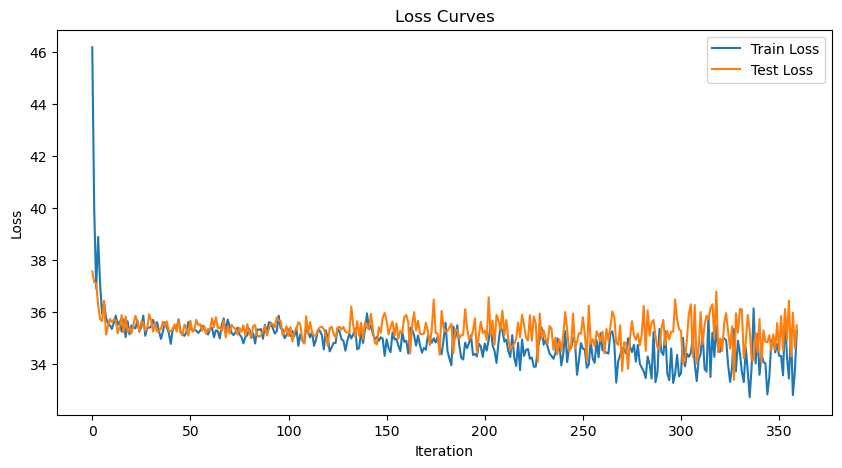

Total correctly classified test set images: 321/1080
Test Set Accuracy: 29.72%




##################################################
#                     User 2                     #
##################################################


Epoch 0, Iteration 0
Train Set Loss: 57.98
Test Set Loss: 52.08
Train set accuracy for a single minibatch: 30.00%
Test set accuracy for a single minibatch: 31.11%


Epoch 1, Iteration 14
Train Set Loss: 35.62
Test Set Loss: 36.01
Train set accuracy for a single minibatch: 22.22%
Test set accuracy for a single minibatch: 22.22%


Epoch 2, Iteration 28
Train Set Loss: 34.74
Test Set Loss: 34.81
Train set accuracy for a single minibatch: 22.22%
Test set accuracy for a single minibatch: 20.00%


Epoch 4, Iteration 6
Train Set Loss: 34.12
Test Set Loss: 34.98
Train set accuracy for a single minibatch: 28.89%
Test set accuracy for a single minibatch: 28.89%


Epoch 5, Iteration 20
Train Set Loss: 34.30
Test Set Loss: 34.92
Train set accuracy for a single min

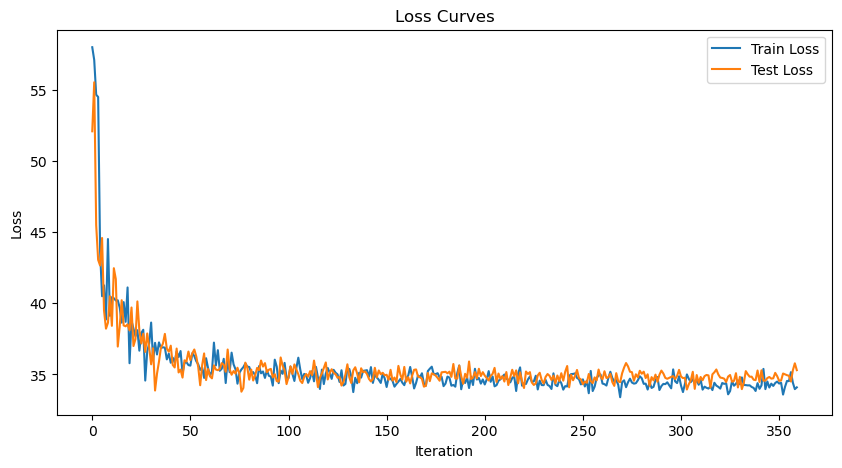

Total correctly classified test set images: 273/1080
Test Set Accuracy: 25.28%




##################################################
#                     User 3                     #
##################################################


Epoch 0, Iteration 0
Train Set Loss: 49.21
Test Set Loss: 42.91
Train set accuracy for a single minibatch: 24.44%
Test set accuracy for a single minibatch: 21.11%


Epoch 1, Iteration 14
Train Set Loss: 34.44
Test Set Loss: 34.99
Train set accuracy for a single minibatch: 24.44%
Test set accuracy for a single minibatch: 20.00%


Epoch 2, Iteration 28
Train Set Loss: 34.82
Test Set Loss: 34.39
Train set accuracy for a single minibatch: 23.33%
Test set accuracy for a single minibatch: 24.44%


Epoch 4, Iteration 6
Train Set Loss: 34.29
Test Set Loss: 35.62
Train set accuracy for a single minibatch: 24.44%
Test set accuracy for a single minibatch: 18.89%


Epoch 5, Iteration 20
Train Set Loss: 34.69
Test Set Loss: 35.43
Train set accuracy for a single min

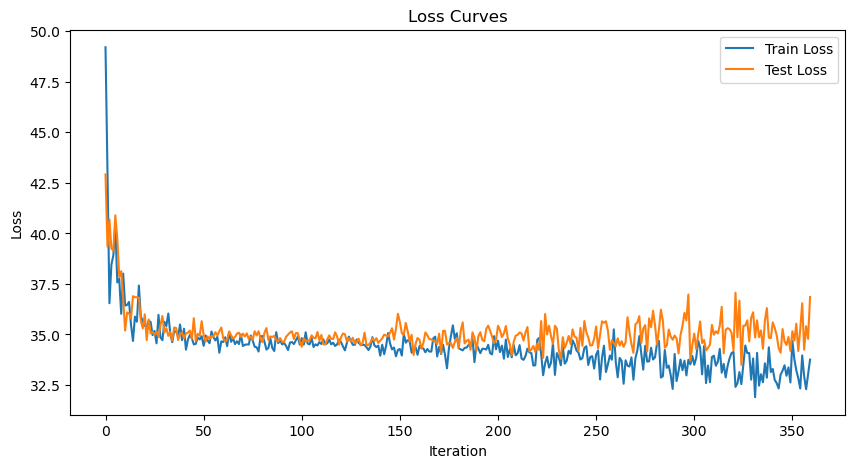

Total correctly classified test set images: 264/1080
Test Set Accuracy: 24.44%




##################################################
#                     User 4                     #
##################################################


Epoch 0, Iteration 0
Train Set Loss: 48.68
Test Set Loss: 46.06
Train set accuracy for a single minibatch: 21.11%
Test set accuracy for a single minibatch: 18.89%


Epoch 1, Iteration 14
Train Set Loss: 35.43
Test Set Loss: 36.22
Train set accuracy for a single minibatch: 23.33%
Test set accuracy for a single minibatch: 20.00%


Epoch 2, Iteration 28
Train Set Loss: 35.20
Test Set Loss: 35.15
Train set accuracy for a single minibatch: 25.56%
Test set accuracy for a single minibatch: 22.22%


Epoch 4, Iteration 6
Train Set Loss: 34.82
Test Set Loss: 35.83
Train set accuracy for a single minibatch: 40.00%
Test set accuracy for a single minibatch: 28.89%


Epoch 5, Iteration 20
Train Set Loss: 35.75
Test Set Loss: 35.64
Train set accuracy for a single min

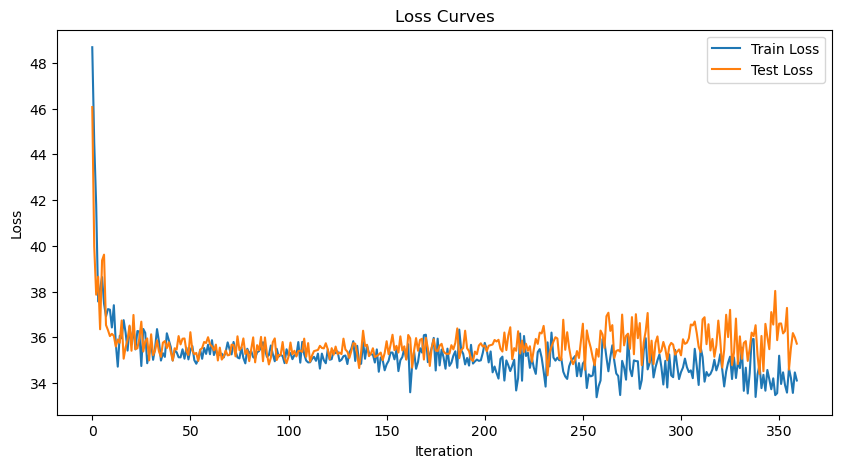

Total correctly classified test set images: 285/1080
Test Set Accuracy: 26.39%




##################################################
#                     User 5                     #
##################################################


Epoch 0, Iteration 0
Train Set Loss: 38.32
Test Set Loss: 37.04
Train set accuracy for a single minibatch: 17.78%
Test set accuracy for a single minibatch: 25.56%


Epoch 1, Iteration 14
Train Set Loss: 36.20
Test Set Loss: 35.00
Train set accuracy for a single minibatch: 24.44%
Test set accuracy for a single minibatch: 27.78%


Epoch 2, Iteration 28
Train Set Loss: 37.25
Test Set Loss: 36.17
Train set accuracy for a single minibatch: 30.00%
Test set accuracy for a single minibatch: 21.11%


Epoch 4, Iteration 6
Train Set Loss: 35.11
Test Set Loss: 35.32
Train set accuracy for a single minibatch: 24.44%
Test set accuracy for a single minibatch: 28.89%


Epoch 5, Iteration 20
Train Set Loss: 34.38
Test Set Loss: 36.95
Train set accuracy for a single min

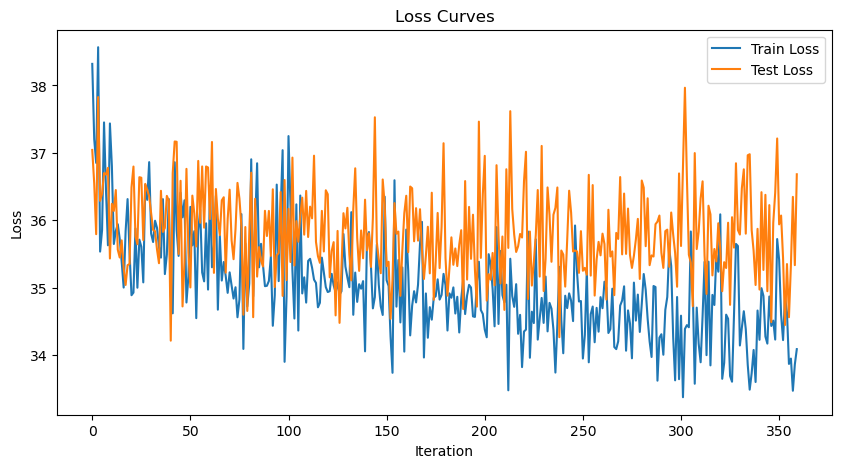

Total correctly classified test set images: 296/1080
Test Set Accuracy: 27.41%




##################################################
#                     User 6                     #
##################################################


Epoch 0, Iteration 0
Train Set Loss: 55.21
Test Set Loss: 53.51
Train set accuracy for a single minibatch: 27.78%
Test set accuracy for a single minibatch: 30.00%


Epoch 1, Iteration 14
Train Set Loss: 34.99
Test Set Loss: 35.56
Train set accuracy for a single minibatch: 32.22%
Test set accuracy for a single minibatch: 25.56%


Epoch 2, Iteration 28
Train Set Loss: 35.62
Test Set Loss: 34.97
Train set accuracy for a single minibatch: 28.89%
Test set accuracy for a single minibatch: 24.44%


Epoch 4, Iteration 6
Train Set Loss: 34.75
Test Set Loss: 35.34
Train set accuracy for a single minibatch: 26.67%
Test set accuracy for a single minibatch: 20.00%


Epoch 5, Iteration 20
Train Set Loss: 34.70
Test Set Loss: 35.25
Train set accuracy for a single min

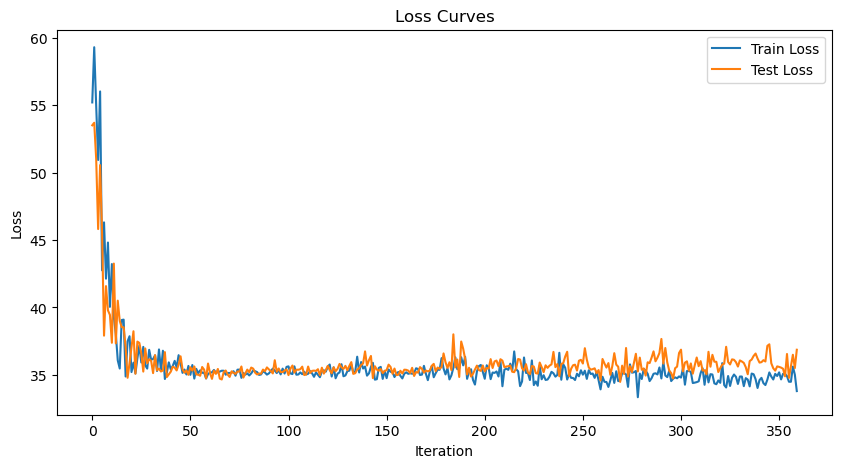

Total correctly classified test set images: 259/1080
Test Set Accuracy: 23.98%




##################################################
#                     User 7                     #
##################################################


Epoch 0, Iteration 0
Train Set Loss: 49.66
Test Set Loss: 52.01
Train set accuracy for a single minibatch: 30.00%
Test set accuracy for a single minibatch: 31.11%


Epoch 1, Iteration 14
Train Set Loss: 42.22
Test Set Loss: 44.22
Train set accuracy for a single minibatch: 23.33%
Test set accuracy for a single minibatch: 23.33%


Epoch 2, Iteration 28
Train Set Loss: 37.47
Test Set Loss: 35.56
Train set accuracy for a single minibatch: 28.89%
Test set accuracy for a single minibatch: 30.00%


Epoch 4, Iteration 6
Train Set Loss: 35.25
Test Set Loss: 34.77
Train set accuracy for a single minibatch: 20.00%
Test set accuracy for a single minibatch: 21.11%


Epoch 5, Iteration 20
Train Set Loss: 35.15
Test Set Loss: 34.51
Train set accuracy for a single min

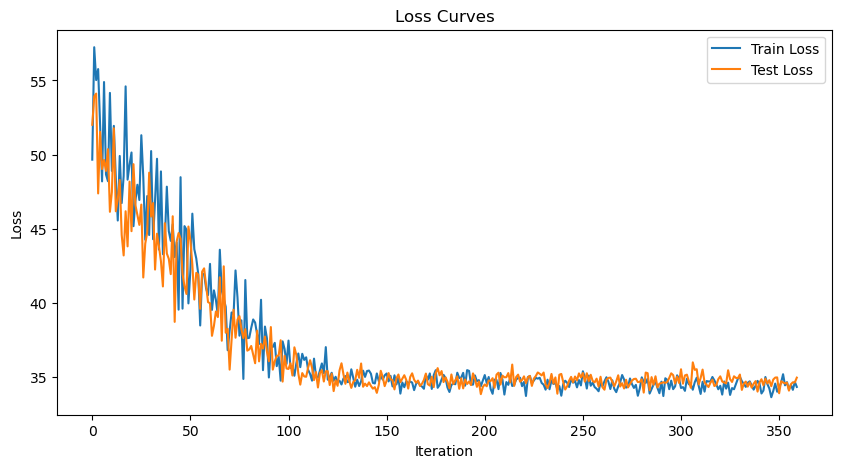

Total correctly classified test set images: 266/1080
Test Set Accuracy: 24.63%




##################################################
#                     User 8                     #
##################################################


Epoch 0, Iteration 0
Train Set Loss: 37.26
Test Set Loss: 37.40
Train set accuracy for a single minibatch: 33.33%
Test set accuracy for a single minibatch: 20.00%


Epoch 1, Iteration 14
Train Set Loss: 34.95
Test Set Loss: 34.65
Train set accuracy for a single minibatch: 33.33%
Test set accuracy for a single minibatch: 27.78%


Epoch 2, Iteration 28
Train Set Loss: 34.32
Test Set Loss: 35.30
Train set accuracy for a single minibatch: 40.00%
Test set accuracy for a single minibatch: 32.22%


Epoch 4, Iteration 6
Train Set Loss: 34.31
Test Set Loss: 34.98
Train set accuracy for a single minibatch: 31.11%
Test set accuracy for a single minibatch: 34.44%


Epoch 5, Iteration 20
Train Set Loss: 33.30
Test Set Loss: 34.66
Train set accuracy for a single min

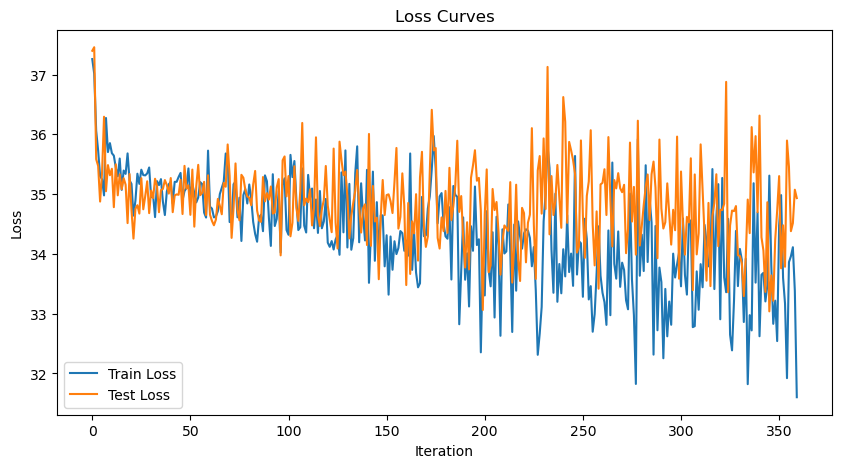

Total correctly classified test set images: 374/1080
Test Set Accuracy: 34.63%




##################################################
#                     User 9                     #
##################################################


Epoch 0, Iteration 0
Train Set Loss: 58.50
Test Set Loss: 54.38
Train set accuracy for a single minibatch: 22.22%
Test set accuracy for a single minibatch: 28.89%


Epoch 1, Iteration 14
Train Set Loss: 35.13
Test Set Loss: 37.02
Train set accuracy for a single minibatch: 25.56%
Test set accuracy for a single minibatch: 24.44%


Epoch 2, Iteration 28
Train Set Loss: 36.06
Test Set Loss: 35.91
Train set accuracy for a single minibatch: 26.67%
Test set accuracy for a single minibatch: 30.00%


Epoch 4, Iteration 6
Train Set Loss: 34.33
Test Set Loss: 35.09
Train set accuracy for a single minibatch: 35.56%
Test set accuracy for a single minibatch: 36.67%


Epoch 5, Iteration 20
Train Set Loss: 33.70
Test Set Loss: 35.98
Train set accuracy for a single min

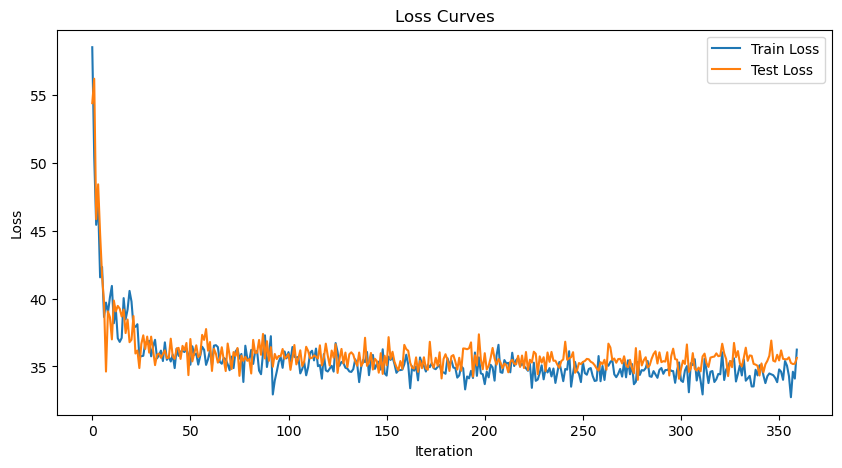

Total correctly classified test set images: 330/1080
Test Set Accuracy: 30.56%


In [10]:
rept = 1
num_users = 9

secs = 1
num_samples = 1080
label_list = [769, 770, 771, 772]

batch_size = 90

compl_acc = list()
for i in range(1, num_users + 1):
    user_acc = list()
    
    for j in range(rept):
        print("\n" * 3)
        print("#" * 50)
        print("#                     User " + str(i) + "                     #")
        print("#" * 50)
        print("\n")

        ## Load the dataset of a specific user
        train_loader, test_loader = create_dataset(i, secs, num_samples, label_list, batch_size)

        ## Classification

        # Dataloader arguments
        dtype = torch.float
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

        # Temporal Dynamics
        num_steps = 25
        num_inputs = secs * 22 * 22

        # Load the network onto CUDA if available
        net = SNN(num_steps, num_inputs, label_list).to(device)

        ### Training
        loss_hist, test_loss_hist = training_network(net, train_loader, test_loader, batch_size)

        loss_printer(loss_hist, test_loss_hist)

        correct, total = test_network(net, test_loader)
        test_printer(correct, total)
        user_acc.append(100 * correct / total)
        
    compl_acc.append(user_acc)

compl_acc = np.array(compl_acc)
    

In [11]:
np.mean(compl_acc, axis=1)

array([29.72222222, 25.27777778, 24.44444444, 26.38888889, 27.40740741,
       23.98148148, 24.62962963, 34.62962963, 30.55555556])